# JuzData: proceso de generacion de hechos - analisis temporal

En el presente notebook se analiza la columna 'exp_fechecho' de nuestro dataset, que contiene las fechas de los hechos que motivaron las causas judiciales. En consecuencia no vamos a meternos con el proceso de distribucion de causas, sino unicamente con su generacion; en particular, me interesa analizar si existe estacionalidad y autocorrelacion temporal en el proceso. 

Esta forma de mirar el problema es interesante para el desafío por dos razones: (1) en sí mismo, en la medida en que conocer el patrón temporal de generación de las hechos nos ayuda a entender mejor la estructura del fenómeno de conflictividad social que da lugar a las causas; y porque (2) entender el proceso desde su estructura temporal es clave para analizar la conveniencia de usar el tiempo como un factor de distribución y cómo afectaría eso la uniformidad entre juzgados.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('penal_df_fec.xlsx')

In [3]:
df['exp_fechecho_dt'] = pd.to_datetime(df['exp_fechecho'])
df[['exp_fechecho','exp_fechecho_dt']].head(10)

,exp_fechecho,exp_fechecho_dt
0,17/2/2014 00:00,2014-02-17
1,NaN,NaT
2,2014-03-12 00:00:00,2014-03-12
3,13/4/2015 00:00,2015-04-13
4,14/5/2015 00:00,2015-05-14
5,2015-01-08 00:00:00,2015-01-08
6,NaN,NaT
7,15/7/2015 00:00,2015-07-15
8,14/5/2015 00:00,2015-05-14
9,NaN,NaT


In [4]:
# convierto 'unknown' en NaN para contabilizar
import itertools as it
for i, col in it.product(df.index,df.columns):
    if df.at[i,col] == 'unknown':
        df.at[i,col] = np.nan

In [5]:
df['exp_fechecho_dt'].notna().sum()

13163

In [6]:
calendar = df['exp_fechecho_dt'].value_counts()
calendar.head()

2017-01-01    42
2016-12-02    32
2016-01-13    30
2016-04-14    30
2016-09-22    29
Name: exp_fechecho_dt, dtype: int64

## Analisis por año

In [7]:
df.columns

Index(['org_idradactual', 'exp_cuij', 'org_idintpri', 'org_cod_pri',
       'org_descorta_pri', 'org_descr_Pri', 'org_idintseg', 'est_id',
       'est_descr', 'exp_anio', 'exp_cuerpos', 'exp_fojas', 'exp_detenidos',
       'exp_id', 'exp_sufijo', 'exp_fechecho', 'exp_fecinidem', 'exp_fecini',
       'exp_fecreg', 'exp_fecsor', 'exp_fecelev', 'exp_letra', 'oju_id',
       'oju_descr', 'exp_ultmov', 'exp_ultmovf', 'den_id', 'den_cod_casoMPF',
       'Tipo_ingreso_MPF', 'org_cod', 'org_descr', 'org_descorta', 'org_den',
       'org_descorta_Den', 'org_descr_Den', 'den_flagrante', 'Comuna',
       'den_barrio', 'den_calle_id', 'den_cod_postal', 'den_fec_hecho',
       'den_fec_ingreso_MPF', 'den_fec_ini_comi', 'den_hora_hecho',
       'den_latitud', 'den_longitud', 'den_tipo_den', 'den_loc_id',
       'den_sin_lugar_hecho', 'den_v_domestica', 'den_v_genero', 'den_zon_id',
       'den_zona', 'filter_.', 'org_destino_act', 'PrimarioDen_id',
       'PrimarioDen_id_oju', 'PrimarioExp_id', 'Pri

In [8]:
df_year_groupby = df.groupby(df['exp_fechecho_dt'].dt.year)
df_year_count = df_year_groupby.count()['exp_cuij'].to_frame(name='hechos')
df_year_count

,hechos
exp_fechecho_dt,
1969.0,32
2006.0,1
2007.0,1
2008.0,2
2009.0,2
2010.0,4
2011.0,1
2012.0,16
2013.0,66


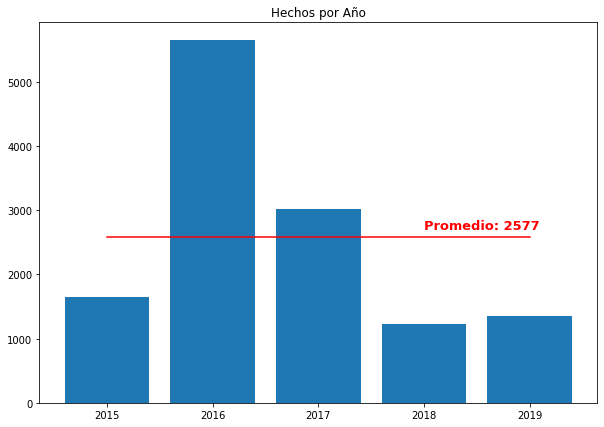

In [9]:
anios = ['2015','2016','2017','2018','2019']
plt.figure(figsize=(10,7))
plt.bar(x=anios,
        height=df_year_count.values.flatten()[-5:])
year_avg = np.mean(df_year_count.values.flatten()[-5:])
plt.plot([year_avg for i in range(5)],c='red')
plt.annotate('Promedio: '+str(int(year_avg)),
             (3,2700),c='red',fontsize=13,
            fontweight='bold')
plt.title('Hechos por Año')
plt.savefig('hechos_por_anio.png')
plt.show()

Estas diferencias entre la cantidad de hechos por año muy probablemente se deba a complicaciones en la migración de datos entre bases (lo hablamos en la última reunión con Yasmin Quiroga).

In [10]:
df_year_count.index = df_year_count.index.astype(int)
df_year_count.index = df_year_count.index.astype(str)

In [11]:
calendar_level = pd.DataFrame()
for i,index in enumerate(calendar.index):
    calendar_level.at[i,'fecha'] = index
    calendar_level.at[i,'hechos'] = calendar[index]
    # llevamos el año al type de df_year_count
    year = str(index.year)
    causas_year = df_year_count.at[year,'hechos']
    calendar_level.at[i,'hechos-level'] = calendar[index] / causas_year

In [12]:
calendar_level.head()

,fecha,hechos,hechos-level
0,2017-01-01,42.0,0.013935
1,2016-12-02,32.0,0.005670
2,2016-01-13,30.0,0.005315
3,2016-04-14,30.0,0.005315
4,2016-09-22,29.0,0.005138


In [13]:
calendar_level['fecha'] = pd.to_datetime(calendar_level['fecha'])

In [14]:
calendar_level_series = pd.Series(data=calendar_level['hechos-level'].values,
                                  index=calendar_level['fecha'])

In [15]:
calendar_level_series.head()

fecha
2017-01-01    0.013935
2016-12-02    0.005670
2016-01-13    0.005315
2016-04-14    0.005315
2016-09-22    0.005138
dtype: float64

## Autocorrelación temporal

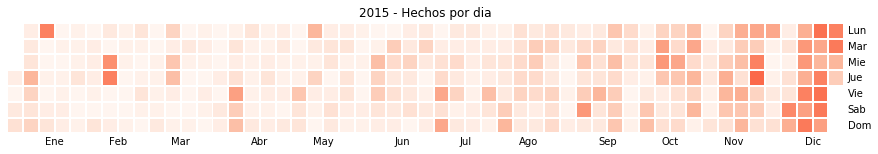

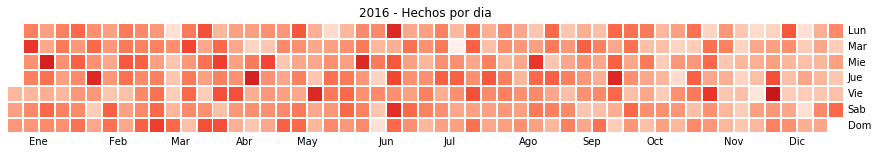

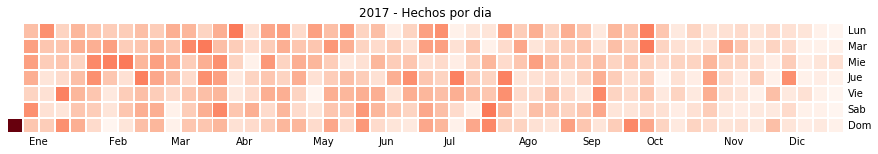

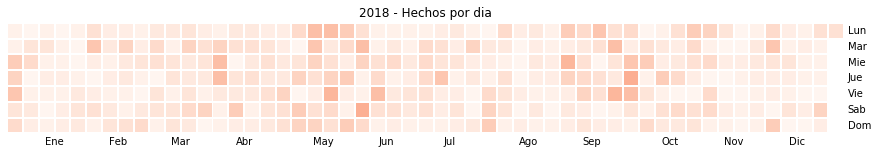

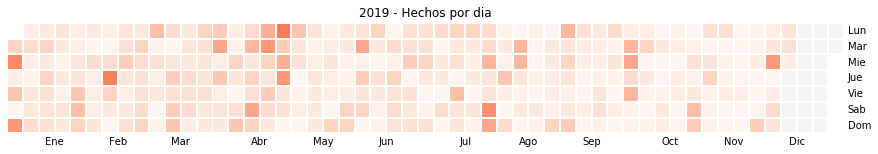

In [16]:
years = [2015,2016,2017,2018,2019]
dias = ['Lun','Mar','Mie','Jue','Vie','Sab','Dom']
meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul',
        'Ago','Sep','Oct','Nov','Dic']
for year in years:
    plt.figure(figsize=(15,10))
    calmap.yearplot(calendar, year=year,
                    daylabels=dias,
                   monthlabels=meses)
    plt.title(str(year) + ' - Hechos por dia')
    file_name = 'calendar_heatmap_'+str(year)+'.png'
    plt.savefig(file_name)
    plt.show()

Que se puede ver en estos heatmaps: no parece haber una marcada estacionalidad (ver analisis mas abajo); el año 2016 presenta muchas mas causas que los demas (ver detalle abajo); y, lo que es mas importante a nuestros fines, se registra una tendencia a la autocorrelacion temporal de la cantidad de causas (lo que se aprecia visualmente en los clusters de más o menor intensidad de color). Esto significa que los hechos que dan lugar a causas se agrupan en clusters temporales (como ya vimos que lo hacen geográficamente).

In [17]:
# llevamos series a df
calendar_df = calendar.to_frame()
calendar_df = calendar_df.reset_index(drop=False)
calendar_df.head()

,index,exp_fechecho_dt
0,2017-01-01,42
1,2016-12-02,32
2,2016-01-13,30
3,2016-04-14,30
4,2016-09-22,29


In [18]:
year = pd.to_datetime('1/1/2015')
year

Timestamp('2015-01-01 00:00:00')

In [19]:
# renombramos
calendar_df = calendar_df.rename(columns={'index':'date','exp_fechecho_dt':'hechos'})
# reordenamos por fecha, reseteamos el indice
calendar_df = calendar_df.sort_values(by='date').reset_index(drop=True)
# filtramos desde 2015
year_filter = pd.to_datetime('1/1/2015')
calendar_df = calendar_df[calendar_df['date'] >= year_filter]
calendar_df.head()

,date,hechos
203,2015-01-01,2
204,2015-01-03,3
205,2015-01-04,5
206,2015-01-05,2
207,2015-01-06,3


Con esta serie armada, podemos visualizar el time series chart

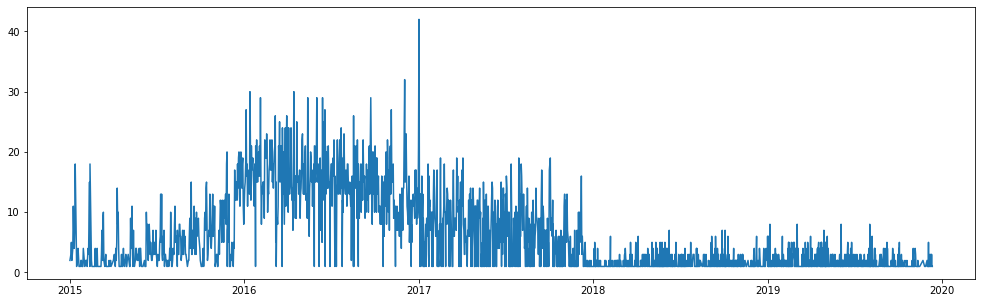

In [20]:
plt.figure(figsize=(17,5))
plt.plot(calendar_df['date'],calendar_df['hechos'])
plt.show()

En el chart se ven algunas de las cualidades generales del proceso: muchas más causas en 2016 (probablemente vinculada con un tema de carga de datos, como hablamos con Yasmín Quiroga en el último encuentro), proceso ruidoso en 2015 y más estable (en su variabilidad) en el 2017, y el 2018 y 2019 con menor cantidad de datos.

Para visualizar la autocorrelación, aparte del heatmap, lo mejor es un scatter (en el eje y, la cantidad de hechos laggeados)

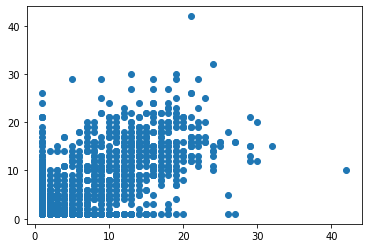

In [21]:
plt.scatter(calendar_df['hechos'],
            calendar_df['hechos'].shift(-1),)
plt.show()

El chart parece indicar una correlación positiva, y además el hecho de que los días que tienen un solo hecho parecen tener un comportamiento diferenciado de los demás. Tendremos en cuenta este insight en lo que sigue. Así se ve nuestro scatter filtrando precisamente esos dias.

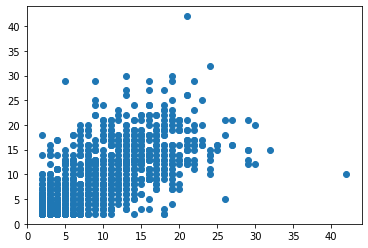

In [22]:
hechos_mayores1 = calendar_df[calendar_df['hechos'] > 1]['hechos']
plt.scatter(hechos_mayores1,
            hechos_mayores1.shift(-1),)
plt.show()

## Análisis de autocorrelación

A continuación vamos a desarrollar funciones para calcular los valores de autocorrelación con cuatro medidas: 
- Pearson (correlación paramétrica tradicional): cociente entre la covarianza y el producto de los desvíos de dos series de datos.
- rho de Spearman (correlación de rangos, no paramétrica): rankea las observaciones de las series y calcula la correlación de Pearson de dicho ranking.
- tau de Kendall (correlación de rangos, no paramétrica): también analiza la correlación ordinal, utilizando comparaciones entre pares de observaciones (estudiando si son concordantes o discordantes, i.e., si las dos series varían en la misma dirección o no).
- Autocorrelación parcial: regresión de una serie sobre sus valores laggeados, se utiliza en la metodología Box-Jenkins.

In [23]:
from scipy.stats import pearsonr, spearmanr, kendalltau

Definimos una función para cálculo de autocorrelaciones y p-values correspondientes, es sus tres versiones.

In [24]:
def auto_corr(corr_function, series, 
              lags = 7, name='',
              alpha = 0.05):
    """
        Calcula autocorrelación y p-values correspondientes para la función de
        correlación especificada.
        
        corr_function - función de correlación: pearsonr, spearmanr, kendalltau
        series - serie de tiempo a analizar
        lags - cuantos períodos considerar
        name - nombre de la función para dataframe
        alpha - alpha para intervalo de PACF
    """
    auto_values = []
    p_values = []
    for i in range(1,lags+1):
        corr_values = corr_function(series[i:],series.shift(i)[i:])
        auto_values.append(corr_values[0])
        p_values.append(corr_values[1])
    
    results = {
        'lag': range(1,lags+1),
        str(name + '_corr'): auto_values,
        str(name + '_p-val'): p_values,
    }
    
    df = pd.DataFrame(results)
    
    return df

In [25]:
test = auto_corr(pearsonr, 
                 calendar_df['hechos'], 
                 lags = 5, name = 'pearson')

In [26]:
test

,lag,pearson_corr,pearson_p-val
0,1,0.713865,0.0
1,2,0.719100,0.0
2,3,0.682517,0.0
3,4,0.676128,0.0
4,5,0.663669,0.0


En el caso de la funcion de autocorrelacion parcial, usamos statsmodels para calcular los valores. Desafortunadamente no viene con p-values, con lo cual los gestionamos con un poco código. Los desvíos para la FACP son $z_{\alpha/2} / \sqrt{n}$, donde $z$ corresponde a una distribución normal. Calculando z lo suficientemente grande como para que el valor +- el desvío sea cero, con la inversa de la distribución normal estándar tenemos nuestro p-value. 

In [27]:
from statsmodels.tsa.stattools import pacf
from scipy.stats import norm

In [28]:
nlags = 7
ejemplo = pacf(calendar_df['hechos'],nlags=nlags)
ejemplo

array([1.        , 0.71404091, 0.4276572 , 0.20897735, 0.16529615,
       0.12424025, 0.11928876, 0.10869849])

In [29]:
norm.cdf(-1.96)

0.024997895148220435

In [30]:
def part_autocorr(series,nlags=7):
    '''
    Devuelve p-values para autocorrelaciones parciales
    
    part_autocorr - array de partial autocorrelations (tomado de pacf) 
    '''
    
    partials = pacf(series,nlags=nlags)
    length = len(partials)
    p_values = []
    
    for i in range(1,length):

        if partials[i] > 0:
            n = series.shape[0] - nlags
            z = partials[i] * np.sqrt(n)
            p_value = norm.cdf(-z) * 2
            p_values.append(p_value)

        elif partials[i] < 0:
            n = series.shape[0] + nlags
            z = partials[i] * np.sqrt(n)
            p_value = norm.cdf(z) * 2
            p_values.append(p_value)

    results = {
        'lag': range(1,nlags+1),
        'partial_corr': partials[1:],
        'partial_p-val': p_values,
    }
    
    df = pd.DataFrame(results)
    
    return df

In [31]:
part_autocorr(calendar_df['hechos'],nlags=5)

,lag,partial_corr,partial_p-val
0,1,0.714041,0.000000e+00
1,2,0.427657,2.869446e-119
2,3,0.208977,7.716703e-30
3,4,0.165296,2.837762e-19
4,5,0.124240,1.523068e-11


In [32]:
# Falta PACF
def corr_df(series, lags = 7): 
    pearson_full = auto_corr(pearsonr, 
                             series, 
                             lags = lags, name = 'pearsonr')

    spearman_full = auto_corr(spearmanr, 
                             series, 
                             lags = lags, name = 'spearmanr')

    kendall_full = auto_corr(kendalltau, 
                             series, 
                             lags = lags, name = 'kendalltau')
    
    partial_full = part_autocorr(series, nlags = nlags)

    correlations_full = pearson_full.merge(spearman_full, on = 'lag')
    correlations_full = correlations_full.merge(kendall_full, on = 'lag')
    correlations_full = correlations_full.merge(partial_full, on = 'lag')
    return correlations_full

In [33]:
corr_full = corr_df(calendar_df['hechos'],lags = 7)
corr_full

,lag,pearsonr_corr,pearsonr_p-val,spearmanr_corr,spearmanr_p-val,kendalltau_corr,kendalltau_p-val,partial_corr,partial_p-val
0,1,0.713865,0.0,0.531745,3.565159e-215,0.444441,1.224593e-196,0.714041,0.000000e+00
1,2,0.719100,0.0,0.534204,1.895856e-217,0.445146,3.422252e-197,0.427657,3.446460e-119
2,3,0.682517,0.0,0.529994,2.265491e-213,0.444400,1.913394e-196,0.208977,8.063865e-30
3,4,0.676128,0.0,0.518484,1.221335e-202,0.432456,4.546909e-186,0.165296,2.917334e-19
4,5,0.663669,0.0,0.495045,4.258643e-182,0.414237,7.786075e-171,0.124240,1.547264e-11
5,6,0.663092,0.0,0.505795,3.170149e-191,0.421616,8.089360e-177,0.119289,9.503573e-11
6,7,0.661362,0.0,0.511944,1.452479e-196,0.427669,8.327819e-182,0.108698,3.638653e-09


En función de lo que vimos más arriba (que los días con un solo hecho parecen tener una estructura temporal diferenciada del resto), corremos las mismas medidas filtrando los días con un solo hecho.

In [34]:
hechos_mayores1_full = corr_df(hechos_mayores1,lags = 7)
hechos_mayores1_full

,lag,pearsonr_corr,pearsonr_p-val,spearmanr_corr,spearmanr_p-val,kendalltau_corr,kendalltau_p-val,partial_corr,partial_p-val
0,1,0.717419,8.217214e-226,0.754697,6.135425e-263,0.584685,2.638443e-203,0.717535,5.173456e-161
1,2,0.695513,1.546427e-206,0.739458,8.090992e-247,0.570800,9.228150e-194,0.372843,7.726118e-45
2,3,0.676560,3.309021e-191,0.721099,6.921223e-229,0.549075,2.518149e-179,0.230876,3.317184e-18
3,4,0.662837,8.860050e-181,0.708717,1.523501e-217,0.540715,7.048827e-174,0.162484,9.190927e-10
4,5,0.679748,2.067262e-193,0.724551,8.607447e-232,0.559645,5.053345e-186,0.195671,1.662595e-13
5,6,0.661447,1.622768e-179,0.702226,1.283610e-211,0.536249,7.761123e-171,0.106406,6.079929e-05
6,7,0.640449,9.159623e-165,0.691460,1.760483e-202,0.527141,4.761961e-165,0.048239,6.909545e-02


El aumento de las medidas de correlación es especialmente notorio en los coeficientes de Spearman y Kendall.

In [35]:
def plot_corr(df, fig, values, pvalues, alpha = 0.01, title='Title'):
    '''
    Plotea funciones de autocorrelacion para el df indicado.
    Los lags significativos en rojo, los demás en azul
    
    df - dataframe con lags, autocorrelaciones y pvalues
    fig - canvas de Matplotlib para plotear
    values - columna con los valores a plotear
    pvalues - columna con los pvalues correspondientes
    alpha - nivel de significación elegido
    title - título
    '''
    pvalue_list = df[pvalues].values
    colors = ['tomato' if pvalue_list[i] > alpha else 'cornflowerblue' for i in range(len((pvalue_list)))]
    fig.bar(x = df['lag'].values,
            height = df[values].values,
            color = colors)
    fig.set_ylim([0, 1])
    fig.set_title(title)

In [36]:
def plot_all_corr(df, alpha = 0.01, title='Title'):
    
    fig, axes = plt.subplots(2, 2,figsize=(10,7),constrained_layout = True)
    plot_corr(df, axes[0, 0], 'pearsonr_corr',
              'pearsonr_p-val', alpha = alpha, title='Pearson')
    plot_corr(df, axes[0, 1], 'spearmanr_corr',
              'spearmanr_p-val', alpha = alpha, title='Spearman')
    plot_corr(df, axes[1, 0], 'kendalltau_corr',
              'kendalltau_p-val', alpha = alpha, title='Kendall')
    plot_corr(df, axes[1, 1], 'partial_corr',
              'partial_p-val', alpha = alpha, title='Partial AutoCorr')

    for ax in axes.flat:
        ax.set(xlabel='lag', ylabel='autocorrelacion')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axes.flat:
        ax.label_outer()

    fig.suptitle(title, fontsize=13)
    plt.show()

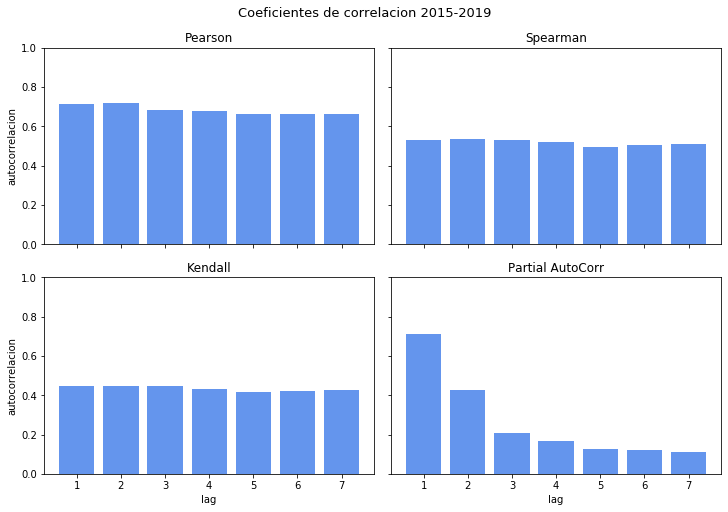

In [37]:
plot_all_corr(corr_full, alpha = 0.01, title = 'Coeficientes de correlacion 2015-2019')

Es decir, una autocorrelación grande, de signo positivo y significativa, para las tres medidas de correlación.

## Autocorrelación por año

### Año 2015

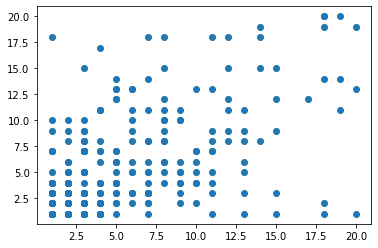

In [38]:
# scatter
serie_2015 = calendar_df[calendar_df['date'].dt.year == 2015]['hechos']
plt.scatter(serie_2015,
            serie_2015.shift(-1),)
plt.show()

In [39]:
corr_2015 = corr_df(serie_2015,lags = 7)
corr_2015

,lag,pearsonr_corr,pearsonr_p-val,spearmanr_corr,spearmanr_p-val,kendalltau_corr,kendalltau_p-val,partial_corr,partial_p-val
0,1,0.562732,5.894046e-28,0.537932,3.001623e-25,0.419379,4.835901e-24,0.563729,2.340077e-23
1,2,0.511947,1.412664e-22,0.447114,5.508145e-17,0.341103,2.186073e-16,0.286053,4.355819e-07
2,3,0.485782,4.068683e-20,0.422452,4.144854e-15,0.320484,1.363975e-14,0.180942,1.393113e-03
3,4,0.395025,3.303910e-13,0.326832,2.822724e-09,0.251893,1.528643e-09,0.011193,8.432737e-01
4,5,0.327096,2.900272e-09,0.211492,1.596934e-04,0.161854,1.066822e-04,-0.023721,6.684415e-01
5,6,0.290739,1.634939e-07,0.183005,1.145016e-03,0.139412,8.649003e-04,0.001775,9.749880e-01
6,7,0.239698,1.873415e-05,0.149927,7.987203e-03,0.112481,7.319370e-03,-0.012862,8.163628e-01


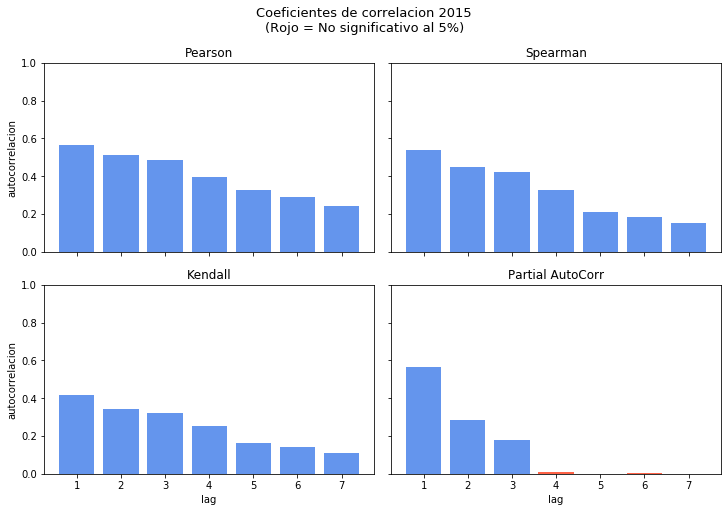

In [40]:
plot_all_corr(corr_2015, alpha = 0.01, title='Coeficientes de correlacion 2015\n(Rojo = No significativo al 5%)')

### Año 2016

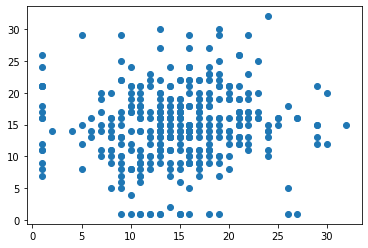

In [41]:
# scatter
serie_2016 = calendar_df[calendar_df['date'].dt.year == 2016]['hechos']
plt.scatter(serie_2016,
            serie_2016.shift(-1),)
plt.show()

En el scatter parece ser más preponderante el peso de los "días de una sola causa", así que repetiremos el análisis con la serie filtrada

In [42]:
corr_2016 = corr_df(serie_2016,lags = 7)
corr_2016

,lag,pearsonr_corr,pearsonr_p-val,spearmanr_corr,spearmanr_p-val,kendalltau_corr,kendalltau_p-val,partial_corr,partial_p-val
0,1,0.080529,0.116590,0.126079,0.013789,0.088611,0.014093,0.080568,0.118715
1,2,0.179318,0.000444,0.215157,0.000023,0.151653,0.000027,0.174363,0.000734
2,3,0.080512,0.117639,0.118438,0.021097,0.084178,0.020017,0.056888,0.270618
3,4,0.058286,0.258301,0.062142,0.228070,0.043272,0.232398,0.019592,0.704395
4,5,0.109955,0.032816,0.157256,0.002196,0.107750,0.002986,0.085054,0.099546
5,6,-0.024804,0.631626,0.005763,0.911313,0.003775,0.917261,-0.055869,0.270497
6,7,0.009467,0.855015,0.018945,0.714600,0.015042,0.679263,-0.024067,0.635016


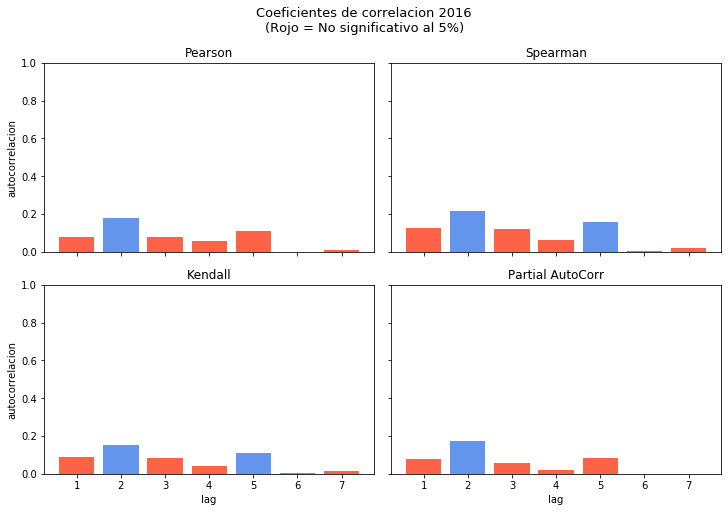

In [43]:
plot_all_corr(corr_2016, alpha = 0.01, title='Coeficientes de correlacion 2016\n(Rojo = No significativo al 5%)')

In [44]:
serie1_2016 = serie_2016[serie_2016 > 1]
corr1_2016 = corr_df(serie1_2016,lags = 7)
corr1_2016

,lag,pearsonr_corr,pearsonr_p-val,spearmanr_corr,spearmanr_p-val,kendalltau_corr,kendalltau_p-val,partial_corr,partial_p-val
0,1,0.145893,0.005227,0.161157,0.002011,0.113338,0.002181,0.145899,0.005703
1,2,0.173308,0.000899,0.220956,0.000021,0.155890,0.000026,0.155545,0.003207
2,3,0.144875,0.005687,0.154185,0.003228,0.108264,0.003508,0.105838,0.044926
3,4,0.037165,0.480861,0.056709,0.281885,0.040721,0.272822,-0.019417,0.707660
4,5,0.155354,0.003082,0.194681,0.000198,0.134821,0.000289,0.120554,0.022361
5,6,0.048441,0.359432,0.042077,0.426070,0.029327,0.430997,0.001262,0.980921
6,7,-0.015983,0.762807,0.012640,0.811356,0.009181,0.805526,-0.066239,0.200795


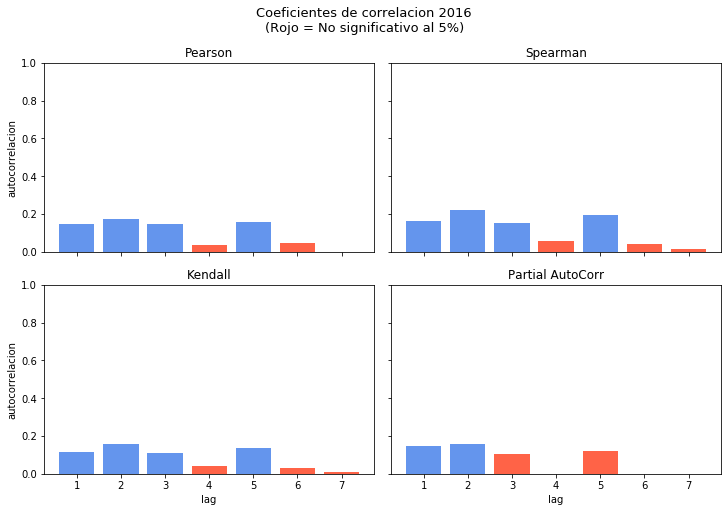

In [45]:
plot_all_corr(corr1_2016, alpha = 0.01, title='Coeficientes de correlacion 2016\n(Rojo = No significativo al 5%)')

Para este año vemos entonces correlaciones más débiles (en especial si incluimos los días de una sola causa). Aún así, sigue claramente presente el fenómeno de la autocorrelación estadísticamente significativa. 

### Año 2017

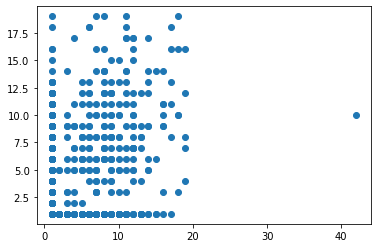

In [46]:
# scatter
serie_2017 = calendar_df[calendar_df['date'].dt.year == 2017]['hechos']
plt.scatter(serie_2017,
            serie_2017.shift(-1),)
plt.show()

In [47]:
corr_2017 = corr_df(serie_2017,lags = 7)
corr_2017

,lag,pearsonr_corr,pearsonr_p-val,spearmanr_corr,spearmanr_p-val,kendalltau_corr,kendalltau_p-val,partial_corr,partial_p-val
0,1,0.302556,4.825195e-13,0.261564,5.233284e-10,0.201170,8.535449e-10,0.288200,2.036697e-11
1,2,0.290985,4.080086e-12,0.288249,6.592036e-12,0.221652,1.444059e-11,0.211761,8.417344e-07
2,3,0.139334,1.109298e-03,0.176697,3.350387e-05,0.136710,3.159864e-05,0.009733,8.209044e-01
3,4,0.159997,1.787304e-04,0.157114,2.341960e-04,0.119011,2.934820e-04,0.070227,1.023781e-01
4,5,0.060863,1.566914e-01,0.075582,7.846081e-02,0.058739,7.417120e-02,-0.023884,5.736546e-01
5,6,0.187446,1.118900e-05,0.186104,1.295775e-05,0.142480,1.509278e-05,0.139667,1.159829e-03
6,7,0.154948,2.974350e-04,0.147466,5.798602e-04,0.113659,5.625785e-04,0.075555,7.885374e-02


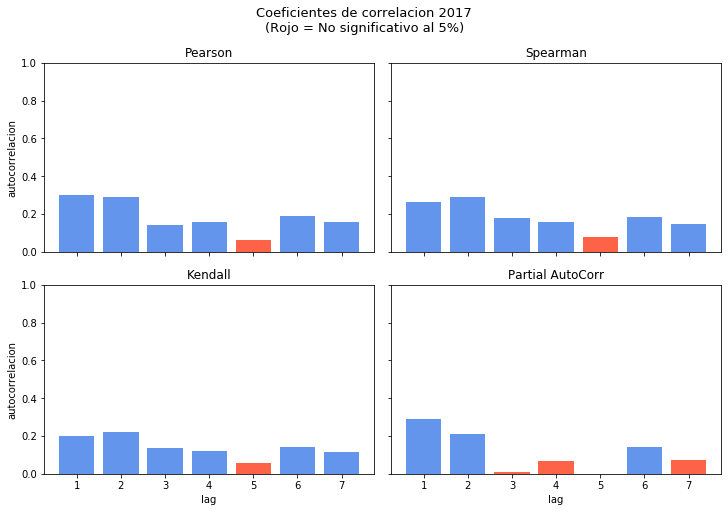

In [48]:
plot_all_corr(corr_2017, alpha = 0.01, title='Coeficientes de correlacion 2017\n(Rojo = No significativo al 5%)')

### Año 2018

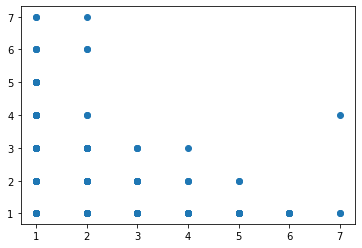

In [49]:
# scatter
serie_2018 = calendar_df[calendar_df['date'].dt.year == 2018]['hechos']
plt.scatter(serie_2018,
            serie_2018.shift(-1),)
plt.show()

Este año presenta una estructura muy diferente a los anteriores; esto está probablemente vinculada a la migración de datos. Además es el año con menos observaciones totales.

In [50]:
corr_2018 = corr_df(serie_2018,lags = 7)
corr_2018

,lag,pearsonr_corr,pearsonr_p-val,spearmanr_corr,spearmanr_p-val,kendalltau_corr,kendalltau_p-val,partial_corr,partial_p-val
0,1,-0.062946,0.067093,-0.053276,0.121309,-0.049406,0.121000,-0.063001,0.065451
1,2,-0.058369,0.089762,-0.045594,0.185213,-0.042356,0.184066,-0.062612,0.067131
2,3,0.001854,0.957079,0.039543,0.250882,0.036813,0.248732,-0.006046,0.859681
3,4,0.007131,0.836123,0.037258,0.279623,0.034516,0.279886,0.003211,0.925813
4,5,0.016296,0.636585,0.014325,0.677902,0.013330,0.676707,0.016801,0.626101
5,6,0.037785,0.273444,-0.002936,0.932202,-0.002851,0.928971,0.040785,0.236905
6,7,0.063335,0.066382,0.074212,0.031403,0.068948,0.031264,0.070594,0.040637


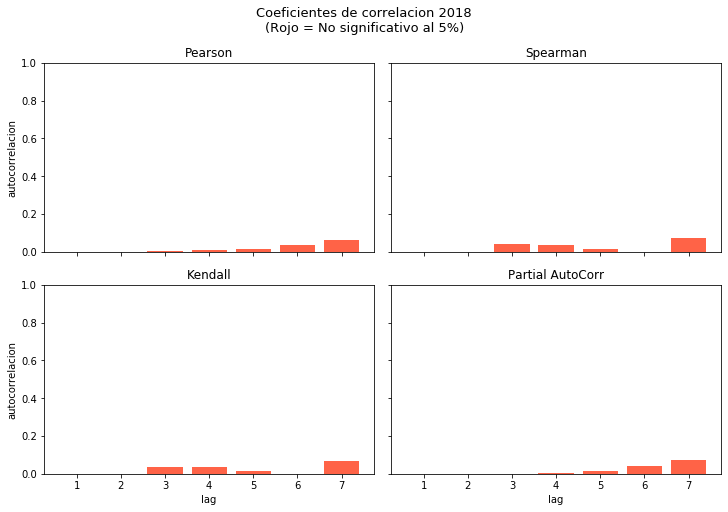

In [51]:
plot_all_corr(corr_2018, alpha = 0.01, title='Coeficientes de correlacion 2018\n(Rojo = No significativo al 5%)')

### Año 2019

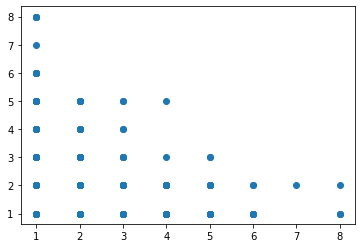

In [52]:
# scatter
serie_2019 = calendar_df[calendar_df['date'].dt.year == 2019]['hechos']
plt.scatter(serie_2019,
            serie_2019.shift(-1),)
plt.show()

Para este año caben las mismas observaciones que para el 2018.

In [53]:
corr_2019 = corr_df(serie_2019,lags = 7)
corr_2019

,lag,pearsonr_corr,pearsonr_p-val,spearmanr_corr,spearmanr_p-val,kendalltau_corr,kendalltau_p-val,partial_corr,partial_p-val
0,1,-0.042357,0.215982,-0.010177,0.766344,-0.009271,0.765919,-0.042009,0.217171
1,2,-0.007314,0.830997,-0.045264,0.186333,-0.041515,0.182681,-0.009045,0.790460
2,3,0.017475,0.610288,0.004628,0.892640,0.004118,0.894971,0.016529,0.630084
3,4,0.001842,0.957180,-0.004689,0.891304,-0.004307,0.890233,0.003186,0.926032
4,5,0.009817,0.774905,-0.018868,0.582548,-0.017275,0.580101,0.010169,0.766992
5,6,-0.024226,0.480574,0.001604,0.962765,0.001328,0.966112,-0.023317,0.493347
6,7,0.024816,0.470221,0.055842,0.103954,0.050779,0.104330,0.022617,0.509886


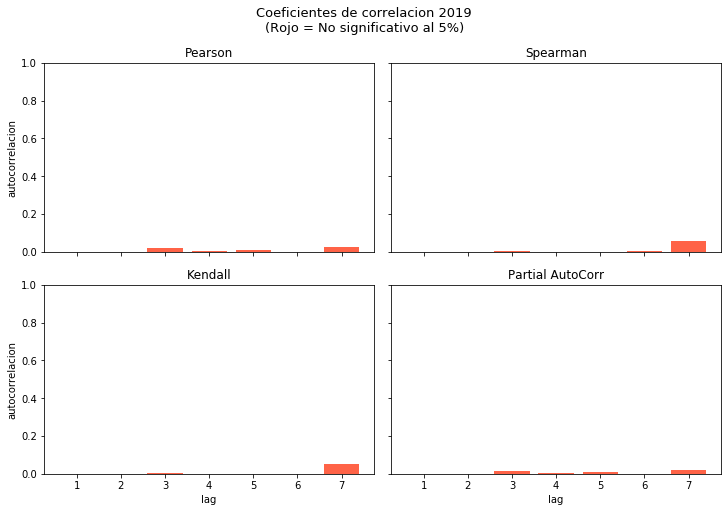

In [54]:
plot_all_corr(corr_2019, alpha = 0.01, title='Coeficientes de correlacion 2019\n(Rojo = No significativo al 5%)')

## Estacionalidad: hechos por meses

In [55]:
df_month_groupby = df.groupby(df['exp_fechecho_dt'].dt.month)
df_month_count = df_month_groupby.count()['exp_cuij'].to_frame(name='hechos')
df_month_count

,hechos
exp_fechecho_dt,
1.0,1184
2.0,1056
3.0,1154
4.0,1152
5.0,1160
6.0,1132
7.0,1111
8.0,1083
9.0,1115


In [56]:
month_avg = np.mean(df_month_count.values)
month_avg

1096.9166666666667

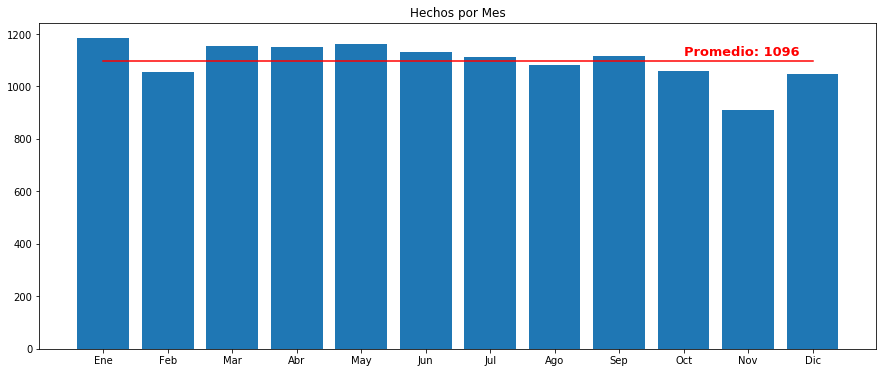

In [57]:
meses = ['Ene','Feb','Mar','Abr','May','Jun',
         'Jul','Ago','Sep','Oct','Nov','Dic']
plt.figure(figsize=(15,6))
plt.bar(x=meses,
        height=df_month_count.values.flatten())
plt.plot([month_avg for i in range(12)],c='red')
plt.annotate('Promedio: '+str(int(month_avg)),
             (9,1120),c='red',fontsize=13,
            fontweight='bold')
plt.title('Hechos por Mes')
plt.savefig('hechos_por_mes.png')
plt.show()

No parece haber fuerte estacionalidad en los meses (faltaría un test formal).

## Estacionalidad: hechos por dias

In [58]:
df_weekday_groupby = df.groupby(df['exp_fechecho_dt'].dt.weekday)
df_weekday_count = df_weekday_groupby.count()['exp_cuij'].to_frame(name='hechos')
df_weekday_count

,hechos
exp_fechecho_dt,
0.0,1867
1.0,1881
2.0,2014
3.0,1930
4.0,1801
5.0,1837
6.0,1833


In [59]:
weekday_avg = np.mean(df_weekday_count.values)
weekday_avg

1880.4285714285713

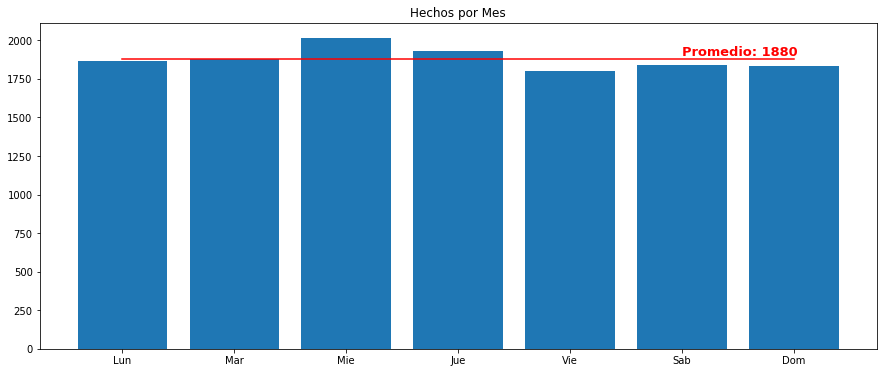

In [60]:
dias = ['Lun','Mar','Mie','Jue','Vie','Sab','Dom']
plt.figure(figsize=(15,6))
plt.bar(x=dias,
        height=df_weekday_count.values.flatten())
plt.plot([weekday_avg for i in range(7)],c='red')
plt.annotate('Promedio: '+str(int(weekday_avg)),
             (5,1900),c='red',fontsize=13,
            fontweight='bold')
plt.title('Hechos por Mes')
plt.savefig('hechos_por_mes.png')
plt.show()

No parece haber fuerte estacionalidad en los días de la semana.

## Discusión Conceptual

- Autocorrelación temporal: modelos empíricos, componente teórico débil (inercia). No aplicaría en nuestro caso. El origen puede estar en la captación de datos? (lo hablamos en la última call, lo sugiere Martina en la minuta).
- Autocorrelación espacial: muy utilizada en criminología. Problema econométrico de selection bias. Teoría relacionada: broken window (no confundir con Rudolph Giuliani).
- Autocorrelación temporal en criminología: efecto contagio (cómo operaría? Priming en el margen)

## Expedientes

In [61]:
# separo exp_cuij en tres columnas
for i in df.index:
    df.at[i,'exp_cuij_1'] = df.at[i,'exp_cuij'][0:2]
    df.at[i,'exp_cuij_2'] = df.at[i,'exp_cuij'][3:11]
    df.at[i,'exp_cuij_3'] = df.at[i,'exp_cuij'][12:13]

In [62]:
df.shape

(37136, 63)

In [63]:
# expedientes unicos segun exp_cuij
df['exp_cuij_2'].unique().shape

(28258,)

In [64]:
# expedientes unicos segun exp_id
df['exp_id'].unique().shape

(32384,)